# Running p-value computation with python API

This is an *VariantSpark* example notebook.

One of the main applications of VariantSpark is discovery of genomic variants correlated with a response variable (e.g. case vs control) using random forest gini importance.

The `chr22_1000.vcf` is a very small sample of the chromosome 22 VCF file from the 1000 Genomes Project.

`chr22-labels-hail.csv` is a CSV file with sample response variables (labels). In fact the labels directly represent the number of alternative alleles for each sample at a specific genomic position. E.g.: column x22_16050408 has labels derived from variants in chromosome 22 position 16050408. We would expect then that position 22:16050408 in the VCF file is strongly correlated with the label x22_16050408.

Both data sets are located in the `..\\data` directory.

This notebook demonstrates how to run importance analysis on these data with *VariantSpark* Hail integration.

Step 1: Create a `HailContext` using `SparkContext` object (here injected as `sc`):

In [1]:
import numpy as np
from unidip import UniDip #pip

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import patches

from varspark.pvalues_calculation import * 
import hail as hl
import varspark.hail as vshl
vshl.init()

using variant-spark jar at '/Users/szu004/dev/VariantSpark/target/variant-spark_2.11-0.5.0-a0-dev0-all.jar'
22/05/06 15:20:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/06 15:20:54 WARN Hail: This Hail JAR was compiled for Spark 3.1.1, running with Spark 3.1.2.
  Compatibility is not guaranteed.
Running on Apache Spark version 3.1.2
SparkUI available at http://192.168.1.12:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.74-0c3a74d12093
LOGGING: writing to /Users/szu004/dev/VariantSpark/examples/hail-20220506-1520-0.2.74-0c3a74d12093.log


Step 2: Load Hail variant dataset `vds` from a sample `.vcf` file.

In [2]:
vds = hl.import_vcf('../data/chr22_1000.vcf')

Step 3: Load labels into Hail table `labels`.

In [3]:
labels = hl.import_table('../data/chr22-labels-hail.csv', impute = True, delimiter=",").key_by('sample')

2022-05-06 15:20:57 Hail: WARN: Name collision: field 'sample' already in object dict. 
  This field must be referenced with __getitem__ syntax: obj['sample']
2022-05-06 15:20:57 Hail: INFO: Reading table to impute column types
2022-05-06 15:20:59 Hail: INFO: Finished type imputation
  Loading field 'sample' as type str (imputed)
  Loading field 'x22_16050408' as type int32 (imputed)
  Loading field 'x22_16050612' as type str (imputed)
  Loading field 'x22_16050678' as type str (imputed)
  Loading field 'x22_16050984' as type int32 (imputed)
  Loading field 'x22_16051107' as type int32 (imputed)
  Loading field 'x22_16051249' as type int32 (imputed)
  Loading field 'x22_16051347' as type int32 (imputed)
  Loading field 'x22_16051453' as type int32 (imputed)
  Loading field 'x22_16051477' as type int32 (imputed)
  Loading field 'x22_16051480' as type int32 (imputed)


Step 4: Annotate dataset samples with labels.

In [4]:
vds = vds.annotate_cols(label = labels[vds.s])
vds.cols().show(3)

2022-05-06 15:20:59 Hail: WARN: cols(): Resulting column table is sorted by 'col_key'.
    To preserve matrix table column order, first unkey columns with 'key_cols_by()'
2022-05-06 15:20:59 Hail: INFO: Coerced almost-sorted dataset
2022-05-06 15:21:00 Hail: INFO: Coerced sorted dataset


+-----------+--------------------+--------------------+--------------------+
| s         | label.x22_16050408 | label.x22_16050612 | label.x22_16050678 |
+-----------+--------------------+--------------------+--------------------+
| str       |              int32 | str                | str                |
+-----------+--------------------+--------------------+--------------------+
| "HG00096" |                  0 | "hahaha"           | "heheh"            |
| "HG00097" |                  1 | "ala ma"           | "1"                |
| "HG00099" |                  1 | "1"                | "1"                |
+-----------+--------------------+--------------------+--------------------+

+--------------------+--------------------+--------------------+
| label.x22_16050984 | label.x22_16051107 | label.x22_16051249 |
+--------------------+--------------------+--------------------+
|              int32 |              int32 |              int32 |
+--------------------+--------------------+--------------------+
|                  0 |                  0 |                  0 |
|                  0 |                  1 |                  1 |
|                  0 |                  1 |                  1 |
+--------------------+--------------------+--------------------+

+--------------------+--------------------+--------------------+
| label.x22_16051347 | label.x22_16051453 | label.x22_16051477 |
+--------------------+--------------------+--------------------+
|              int32 |              int32 |              int32 |
+--------------------+--------------------+--------------------+
|                  0 |                  0 |                  0 |
|                  1 |                  1 |                  0 |
|                  1 |                  1 |                  0 |
+--------------------+--------------------+--------------------+

+--------------------+
| label.x22_16051480 |
+--------------------+
|              int32 |
+--------------------+
|                  0 |
|                  1 |
|                  1 |
+--------------------+
showing top 3 rows

Step 5: Build the random forest model with `label.x22_16050408` as the respose variable

In [5]:
rf_model = vshl.random_forest_model(y=vds.label['x22_16050408'],
                x=vds.GT.n_alt_alleles(), seed = 13, mtry_fraction = 0.05, min_node_size = 5, max_depth = 10)
rf_model.fit_trees(100, 50)

2022-05-06 15:21:00 Hail: INFO: Coerced almost-sorted dataset


Step 6: Display the results: print OOB error calculated variable importance.

In [6]:
print("OOB error: %s" % rf_model.oob_error())
impTable = rf_model.variable_importance()
impTable.order_by(hl.desc(impTable.importance)).show(10)

OOB error: 0.007326007326007326


2022-05-06 15:21:05 Hail: INFO: Coerced sorted dataset


,,,
locus,alleles,importance,splitCount
locus<GRCh37>,array<str>,float64,int64
22:16050408,"[""T"",""C""]",4.22e+01,73
22:16050678,"[""C"",""T""]",2.37e+01,38
22:16052838,"[""T"",""A""]",1.85e+01,24
22:16053727,"[""T"",""G""]",1.71e+01,17
22:16051107,"[""C"",""A""]",1.29e+01,23
22:16053197,"[""G"",""T""]",1.18e+01,15
22:16051480,"[""T"",""C""]",1.16e+01,25
22:16053797,"[""T"",""C""]",1.08e+01,13


Step 7: Obtaiin the variable importance table and their `splitCount`

In [7]:
df = impTable.order_by(hl.desc(impTable.importance)).to_spark(flatten=False).toPandas()
df['log_importance'] = df.importance.apply(np.log)

In [18]:
class PValueCalculator:
    
    def __init__(self, df):
        self._df = df

    @classmethod
    def from_imp_table(cls,impTable):
        impDf = impTable.filter(impTable.splitCount >= 1).to_spark(flatten=False).toPandas()
        df = impDf.assign(logImportance = np.log(impDf.importance))
        return PValueCalculator(df)

    def plot_log_densities(self, ax, min_split_count = 1, max_split_count=6, palette = 'Set1',
                      xLabel = 'log(importance)', yLabel = 'density'):
        #TODO test preconditions
        no_lines = max_split_count - min_split_count + 1
        colors= sns.mpl_palette(palette, no_lines)
        df = self._df
        for i,c in zip(range(min_split_count, max_split_count + 1), colors):
            sns.kdeplot(df.logImportance[df.splitCount >= i],
                        ax = ax, c=c, bw_adjust=0.5) #bw low show sharper distributions
    
    
        #ax.legend(labels=range(1,n_lines), bbox_to_anchor=(1,1))
        ax.set_xlabel(xLabel)
        ax.set_ylabel(yLabel)


    def plot_log_hist(self, ax, split_count, bins = 100,
                          xLabel = 'log(importance)', yLabel = 'count'):
        # check preconditions
        df = self._df
        sns.histplot(df.logImportance[df.splitCount >= split_count], ax = ax, bins=bins)
        ax.set_xlabel(xLabel)
        ax.set_ylabel(yLabel)
        
        
    def compute_p_values(self, countThreshold = 2, pValue = 0.05, **kwargs):
        impDfWithLog = self._df[self._df.splitCount >= countThreshold]
        pValueResult = run_it_importances(impDfWithLog.logImportance, pValue)
        #return impDfWithLog.assign(pValue =  pValueResult['ppp'])
        return (impDfWithLog.assign(pvalue = pValueResult['ppp']), pValueResult)   
    
    
    def find_split_count_th(self, min_split_count = 1, max_split_count=6, ntrials=1000):
        df = self._df
        for splitCountThreshold in range(min_split_count,max_split_count + 1):
            dat = np.msort(df[df['splitCount']>splitCountThreshold]['logImportance'])
            intervals = UniDip(dat, ntrials=ntrials).run() #ntrials can be increased to achieve higher robustness
            if len(intervals) <= 1: 
                break
        # TODO: check if converged !!!
        return splitCountThreshold

In [19]:
pValCalc = PValueCalculator.from_imp_table(impTable)

Setp 8: Determine the cutoff (of how many times a variable was used to split a tree) to get a unimodal density.

In [20]:
autoSplitCountTh = pValCalc.find_split_count_th()
print("The automatically selected SplitCount Threshold is %s" % autoSplitCountTh)

The automatically selected SplitCount Threshold is 1


Step 9: Display (A) Density graphs of the Gini importance scores with different colours indicating the SplitCounts of a variable. (B) Histogram of Gini importances scores of variables with `SplitCountThreshold` selected

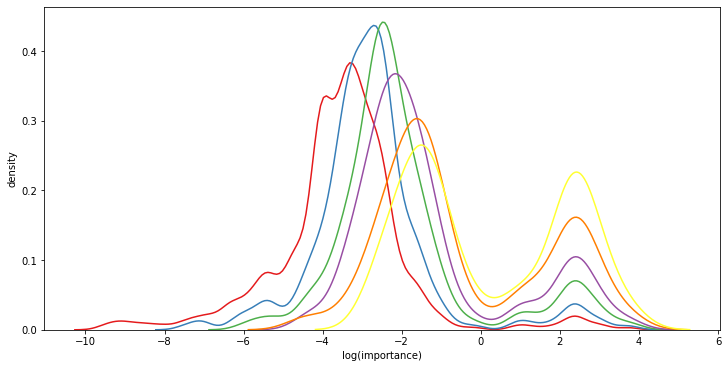

In [11]:
#plt.rcParams['figure.figsize'] = [15, 10]
#SMALL_SIZE = 12
#MEDIUM_SIZE = 14
#BIGGER_SIZE = 16
#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
#plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
#plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
#plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax1 = plt.subplots(figsize=(10, 5), layout='constrained')
pValCalc.plot_log_densities(ax1)
plt.show()

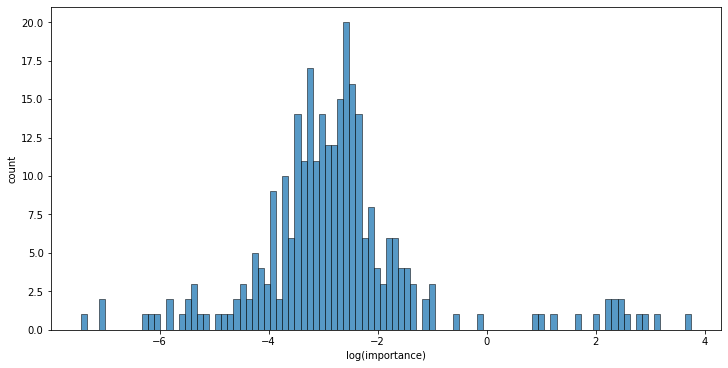

In [12]:
fig, ax2 = plt.subplots(figsize=(10, 5), layout='constrained')
pValCalc.plot_log_hist(ax2, 2)
plt.show()

Step 10: Preparing the DataFrame for the variant p-value calculation

Step 11: Computing p-values and keeping the significant ones.

In [15]:
pvalueDF, info = pValCalc.compute_p_values(countThreshold = 2)
print("C = %s" % info['C'])
pvalueDF

C = 5.96612585974164


,locus,alleles,importance,splitCount,logImportance,pvalue
0,"(22, 16050408)","[T, C]",42.193208,73,3.742259,5.990086e-11
1,"(22, 16050612)","[C, G]",2.776943,8,1.021351,4.470102e-05
2,"(22, 16050678)","[C, T]",23.653666,38,3.163518,1.741376e-09
3,"(22, 16051107)","[C, A]",12.874493,23,2.555248,4.505101e-08
4,"(22, 16051249)","[T, C]",0.035682,2,-3.333114,6.948458e-01
...,...,...,...,...,...,...
567,"(22, 17796497)","[A, G]",0.014301,2,-4.247424,9.419628e-01
568,"(22, 17796520)","[G, A]",0.062584,2,-2.771250,4.521274e-01
569,"(22, 17796921)","[T, TTAAC]",0.002924,2,-5.834689,9.997586e-01
570,"(22, 17796926)","[T, TA]",0.015958,4,-4.137791,9.253603e-01


In [14]:
pvalueDF.sort_values('pvalue')

,locus,alleles,importance,splitCount,logImportance,pvalue
0,"(22, 16050408)","[T, C]",42.193208,73,3.742259,5.990086e-11
2,"(22, 16050678)","[C, T]",23.653666,38,3.163518,1.741376e-09
13,"(22, 16052838)","[T, A]",18.491606,24,2.917317,6.732568e-09
20,"(22, 16053727)","[T, G]",17.053610,17,2.836362,1.039200e-08
3,"(22, 16051107)","[C, A]",12.874493,23,2.555248,4.505101e-08
...,...,...,...,...,...,...
291,"(22, 17733865)","[T, A]",0.002206,2,-6.116751,9.999379e-01
143,"(22, 17697781)","[A, C]",0.001850,2,-6.292477,9.999749e-01
247,"(22, 17725406)","[G, A]",0.000873,2,-7.043752,9.999997e-01
243,"(22, 17725209)","[C, G]",0.000863,2,-7.054950,9.999997e-01
